## Retrieve the data from the API

In [1]:
from csv import DictReader
from datetime import datetime

import matplotlib
import pandas as pd
import requests
import seaborn
import numpy as np
import matplotlib.pyplot as plt

from ete3 import NCBITaxa
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

agbio_species_names = ['Phoenix dactylifera','Malus domestica','Triticum aestivum','Allium cepa','Elaeis oleifera x Elaeis guineensis','Oncorhynchus mykiss','Actinidia chinensis','Vigna unguiculata','Solanum lycopersicum','Saccharum hybrid cultivar','Oncorhynchus keta','Oryza sativa Japonica Group','Cajanus cajan','Bos indicus','Sorghum bicolor','Zea mays','Juglans regia','Macropodus opercularis','Bos','Haplochromini','Clupea harengus','Vitis vinifera','Brassica napus','Morone chrysops','Larimichthys polyactis','Setaria italica','Bos taurus','Secale cereale','Dicentrarchus labrax','Triticum dicoccoides','Phaseolus vulgaris','Danio rerio','Ovis dalli dalli','Hordeum vulgare subsp. vulgare','Capra hircus','Sus scrofa','Capsicum annuum','Gossypium hirsutum','Oncorhynchus nerka','Thunnus thynnus','Bison bonasus','Oncorhynchus tshawytscha','Capsicum','Salmo salar','Labeo rohita','Neogale vison','Brassica rapa','Ananas comosus','Bubalus bubalis','Gossypium herbaceum','Ovis aries','Elaeis guineensis','Cannabis sativa','Nicotiana tabacum','Theobroma cacao','Oreochromis niloticus','Oncorhynchus kisutch','Digitaria exilis','Ovis orientalis','Oryza sativa Indica Group','Arabidopsis thaliana','Daucus carota subsp. sativus','Ovis ammon','Hordeum vulgare','Cucurbita pepo','Glycine max','Cucumis sativus var. sativus','Bos grunniens','Medicago truncatula','Bison bison bison','Phaseolus lunatus','Oryza rufipogon','Brassica oleracea','Linum usitatissimum','Helianthus annuus','Cicer arietinum','Monodelphis domestica','Oryza sativa','Eragrostis tef','Nothobranchius furzeri','Lactuca sativa','Anas platyrhynchos platyrhynchos','Anas platyrhynchos','Gallus gallus','Meleagris gallopavo','Alectoris rufa','Coturnix japonica','Anser cygnoides']

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Function to Annotate the rows with taxonomy lineage

In [2]:
ete_db = NCBITaxa()

def add_lineage_names(record_set):
    required_ranks = ['class']
    all_records = []
    for record in record_set:
        # Add information about lineage of the taxonomy
        lineage = ete_db.get_lineage(int(record.get('taxonomyId')))
        # Get the rank of each taxonomy ids
        ranks = ete_db.get_rank(lineage)
        # Get the taxonomy of the required ranks
        for required_rank in required_ranks:
            taxid_for_rank = [i for i in ranks if ranks[i] == required_rank]
            if taxid_for_rank:
                # Get the scientific names of the rank
                sci_name_of_required_rank = ete_db.get_taxid_translator(taxid_for_rank)[taxid_for_rank[0]]
                record[required_rank] = sci_name_of_required_rank
        all_records.append(record)
    return all_records


## Prepare EVA release metrics

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 563191 was translated into 187327
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469587 was translated into 817
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469586 was translated into 818
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


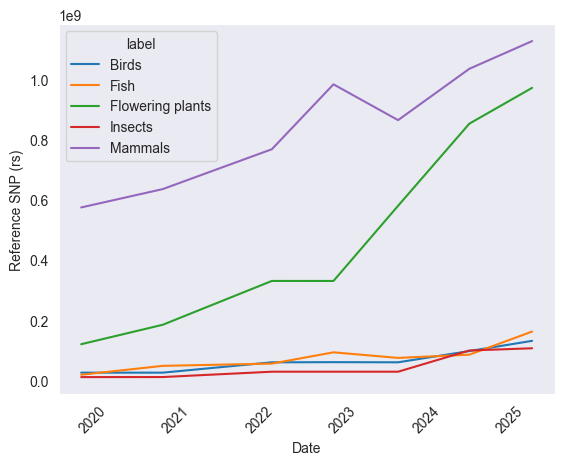

In [3]:

response = requests.get('https://www.ebi.ac.uk/eva/webservices/release/v2/stats/per-species')
response.raise_for_status()
release_metrics = response.json()

response = requests.get('https://www.ebi.ac.uk/eva/webservices/release/v1/info')
response.raise_for_status()
release_info = response.json()
version_to_date = {}
for release in release_info:
    version_to_date[release.get('releaseVersion')] = release['releaseDate'].split('T')[0]

for record in release_metrics:
    # Add date of the release
    record['releaseDate'] = version_to_date[record['releaseVersion']]
all_records = add_lineage_names(release_metrics)
eva_raw_metrics = pd.DataFrame.from_dict(all_records)
eva_raw_metrics['Date'] = pd.to_datetime(eva_raw_metrics['releaseDate'], format='%Y-%m-%d')

eva_raw_metrics['label'] = eva_raw_metrics['class']

# Change all the label not in the list bellow to others
accepted_classes = {'Aves': 'Birds','Insecta':'Insects','Actinopteri': 'Fish','Mammalia': 'Mammals','Magnoliopsida': 'Flowering plants'}

# Check ~ which somehow means "NOT IN" in pandas
eva_raw_metrics.loc[~eva_raw_metrics['label'].isin(accepted_classes), 'label'] = 'Others'
eva_raw_metrics = eva_raw_metrics.replace({'label': accepted_classes})

eva_raw_metrics = eva_raw_metrics[eva_raw_metrics.label != 'Others']

# Group by class and releaseDate to add up all rs from a specific class
eva_metrics_per_class = eva_raw_metrics.groupby(['label', 'Date'])[["currentRs"]].sum().reset_index()
eva_metrics_per_class = eva_metrics_per_class.rename(columns={'currentRs': 'Reference SNP (rs)'})
eva_metrics_per_class['source'] = 'EVA'
g2 = seaborn.lineplot(data=eva_metrics_per_class, x='Date', y='Reference SNP (rs)', hue='label')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

## Prepare dbsnp non human release metrics

## Separate the species on if they are of interest for Agriculture

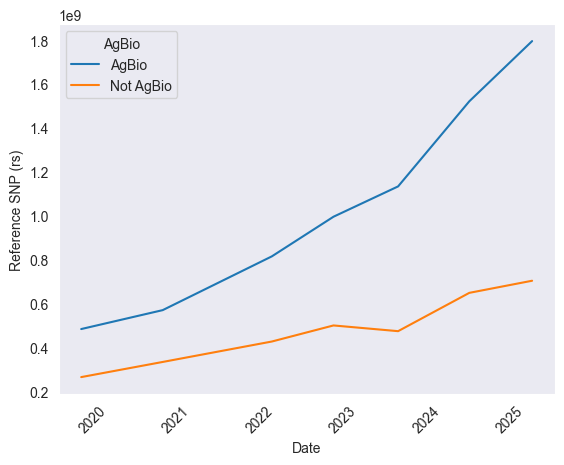

In [4]:
eva_raw_metrics['AgBio'] = 'Not AgBio'
eva_raw_metrics.loc[eva_raw_metrics['scientificName'].isin(agbio_species_names), 'AgBio'] = 'AgBio'
eva_metrics_per_agbio = eva_raw_metrics.groupby(['AgBio', 'Date'])[["currentRs"]].sum().reset_index()
eva_metrics_per_agbio = eva_metrics_per_agbio.rename(columns={'currentRs': 'Reference SNP (rs)'})
eva_metrics_per_agbio['source'] = 'EVA'
g2 = seaborn.lineplot(data=eva_metrics_per_agbio, x='Date', y='Reference SNP (rs)', hue='AgBio')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

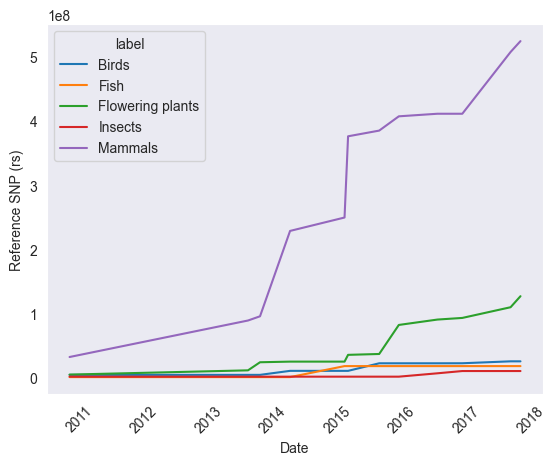

In [5]:
metrics = []
with open('dbsnp_non_human_builds.tsv') as open_file:
    reader = DictReader(open_file, delimiter='\t')
    for record in reader:
        name_translator = ete_db.get_name_translator([record.get('Organism')])
        record['taxonomyId'] = name_translator[record.get('Organism')][0]
        record['Reference SNP (rs)'] = int(record['Reference SNP (rs)'])
        metrics.append(record)

metrics = add_lineage_names(metrics)
dbsnp_raw_metrics = pd.DataFrame(metrics)
dbsnp_raw_metrics['Date'] = pd.to_datetime(dbsnp_raw_metrics['Date'], dayfirst=True)
dbsnp_raw_metrics = dbsnp_raw_metrics.sort_values('Date')
organism_info = dbsnp_raw_metrics[['Organism', 'class', 'taxonomyId']].drop_duplicates().set_index('taxonomyId')

# Pivot the table: rows = dates, columns = organisms, values = Reference SNP (rs)
pivot_df = dbsnp_raw_metrics.pivot(index='Date', columns='taxonomyId', values='Reference SNP (rs)')

# Forward fill missing values by organism (columns)
pivot_df_ffill = pivot_df.ffill()
pivot_df_ffill.fillna(0, inplace=True)

filled_df = pivot_df_ffill.reset_index().melt(id_vars='Date', var_name='taxonomyId', value_name='Reference SNP (rs)')
filled_df = filled_df.merge(organism_info, left_on='taxonomyId', right_index=True, how='left')
filled_df = filled_df.sort_values(['Date', 'Organism']).reset_index(drop=True)

filled_df['label'] = filled_df['class']
#
# Change all the label not in the list below to others
accepted_classes = {'Aves': 'Birds','Insecta':'Insects','Actinopteri': 'Fish','Mammalia': 'Mammals','Magnoliopsida': 'Flowering plants'}
#
# Check ~ which somehow means "NOT IN" in pandas
filled_df.loc[~filled_df['label'].isin(accepted_classes), 'label'] = 'Others'
dbsnp_cumsum_metrics = filled_df.replace({'label': accepted_classes})

dbsnp_cumsum_metrics = dbsnp_cumsum_metrics[dbsnp_cumsum_metrics.label != 'Others']

# Group by class and releaseDate to add up all rs from a specific class
dbsnp_non_human_metrics = dbsnp_cumsum_metrics.groupby(['label', 'Date'])[["Reference SNP (rs)"]].sum().reset_index()
dbsnp_non_human_metrics['source'] = 'dbSNP'
g2 = seaborn.lineplot(data=dbsnp_non_human_metrics, x='Date', y='Reference SNP (rs)', hue='label')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

## Prepare dbsnp Human release metrics

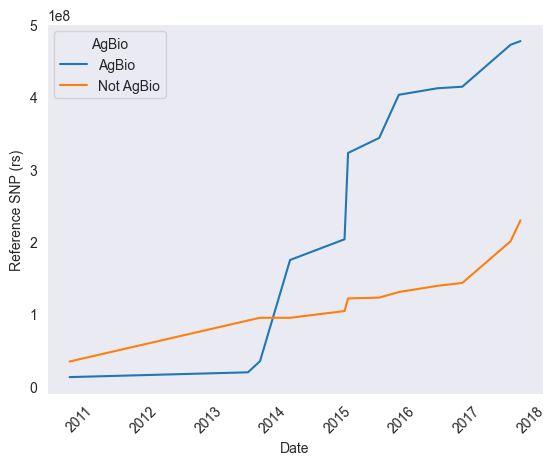

In [6]:
dbsnp_cumsum_metrics['AgBio'] = 'Not AgBio'
dbsnp_cumsum_metrics.loc[dbsnp_cumsum_metrics['Organism'].isin(agbio_species_names), 'AgBio'] = 'AgBio'
dbsnp_metrics_per_agbio = dbsnp_cumsum_metrics.groupby(['AgBio', 'Date'])[["Reference SNP (rs)"]].sum().reset_index()
dbsnp_metrics_per_agbio['source'] = 'dbSNP'
g2 = seaborn.lineplot(data=dbsnp_metrics_per_agbio, x='Date', y='Reference SNP (rs)', hue='AgBio')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

In [7]:

dbsnp_human_metrics = pd.read_csv('dbsnp_human_release_metrics_per_year.tsv', sep='\t')
dbsnp_human_metrics['Date'] = pd.to_datetime(dbsnp_human_metrics['Year'], format='%Y')
dbsnp_human_metrics['label'] = 'Human'
dbsnp_human_metrics['source'] = 'dbSNP'

## Prepare timeline data

In [69]:
colors = [
    '#1f77b4',  # Dark blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Grey
    '#bcbd22',  # Yellow
    '#17becf'   # Light blue
]

type_to_plot_info = {
    'event': {'label': 'Significant event', 'marker':'^', 'color':'#d62728', 'markerfacecolor':'#d62728'},
    # 'standard': {'marker':'o', 'color':'#17becf', 'markerfacecolor':'#17becf'},
    # 'genome': {'marker':'o', 'color':'#17becf', 'markerfacecolor':'#17becf'},
    'population': {'label': 'Population resequencing', 'marker':'o', 'color':'#17becf', 'markerfacecolor':'#17becf'},
    'pangenome': {'label': 'Pangenome', 'marker':'x', 'color':'#2ca02c', 'markerfacecolor':'#2ca02c'}
}

events_dates_labels = [
    {'label': 'fist point', 'date_str':'1998-01-01'}, # Not visible on the graph
    {'label': 'Creation of dbSNP', 'date_str':'1999-08-09', 'type': 'event'},
    # {'label': 'Human HapMap Project', 'date_str':'2003-12-18', 'type': 'population'},
    {'label': '$100,000 genome', 'date_str':'2009-10-01', 'type': 'event'},
    {'label': 'The 1001 genomes\nArabidopsis thaliana', 'date_str':'2009-04-27', 'type': 'population'},
    {'label': '$10,000 genome', 'date_str':'2011-09-01', 'type': 'event'},
    {'label': 'Maize HapMap2', 'date_str':'2012-06-03', 'type': 'population'},
    {'label': 'The 3,000 Rice Genomes Project', 'date_str':'2014-05-24', 'type': 'population'},
    {'label': '$1,000 genome', 'date_str':'2019-01-01', 'type': 'event'},
    {'label': 'PacBio Hifi chemistry', 'date_str':'2019-8-15', 'type': 'event'},
    {'label': '1000 Bull Genomes Project', 'date_str':'2019-12-03', 'type': 'population'},
    {'label': 'Rice pan-genome resource ', 'date_str':'2020-04-07', 'type': 'pangenome'},
    {'label': 'Pan-Genome of Soybeans', 'date_str':'2020-08-09', 'type': 'pangenome'},
    {'label': 'The sorghum pan-genome', 'date_str':'2021-04-20', 'type': 'pangenome'},
    {'label': '26 diverse maize genomes', 'date_str':'2021-09-06', 'type': 'population'},
    {'label': 'Tomato pan-genome', 'date_str':'2022-08-06', 'type': 'pangenome'},
    {'label': 'Arabidopsis thaliana pan-genome', 'date_str':'2022-12-19', 'type': 'pangenome'},
    {'label': 'last point', 'date_str':'2026-01-01'}  # Not visible on the graph
]

range_dates_labels = [
    {'label': '2nd generation sequencing', 'date_start_str':'2005-01-01', 'date_end_str':'2025-05-01', 'level': 1, 'color': '#e377c2'},
    {'label': '3rd generation sequencing', 'date_start_str':'2010-01-01', 'date_end_str':'2025-05-01', 'level': 1.7, 'color': '#bcbd22'}
]

for info_dict in events_dates_labels:
    info_dict['date'] = datetime.strptime(info_dict['date_str'], '%Y-%m-%d')
for info_dict in range_dates_labels:
    info_dict['date_start'] = datetime.strptime(info_dict['date_start_str'], '%Y-%m-%d')
    info_dict['date_end'] = datetime.strptime(info_dict['date_end_str'], '%Y-%m-%d')

## Figure 1 plotting functions

In [70]:
import matplotlib.lines as mlines

def line_plot_metrics(metrics, ax):
    """PLot a line for each label in the metrics dataframe. separate the line style using the source column"""
    seaborn.set_style('white')
    seaborn.lineplot(ax=ax, data=metrics, x='Date', y='Reference SNP (rs)', hue='label', style='source')
    ax.set_ylabel('Reference SNP (Billion)', fontdict={'size': 16, 'weight': 'bold'})
    ax.get_legend().remove()

def plot_time_line(events_dates_labels, range_dates_labels, ax):
    dates = [d.get('date') for d in events_dates_labels]
    ax.plot(dates, np.zeros_like(dates),"-", color="k")  # Baseline.
    for event_type in type_to_plot_info:
        dates_for_type = [d.get('date') for d in events_dates_labels if 'type' in d and d.get('type') == event_type]
        if dates_for_type:
            ax.vlines(dates_for_type, 0, -.3, color=type_to_plot_info.get(event_type).get('color'))  # The vertical stems.
            ax.plot(dates_for_type, np.zeros_like(dates_for_type), **type_to_plot_info.get(event_type), linestyle='None')  # Baseline.
        # annotate lines

    for info_dict in events_dates_labels:
        ax.annotate(info_dict.get('label'), xy=(info_dict.get('date'), -0.3),
                    xytext=(8, 0), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="top" , rotation=70)

    for info_dict in range_dates_labels:
        arrow = mpatches.FancyArrowPatch(
            (info_dict.get('date_start'), info_dict.get('level', 1)),
            (info_dict.get('date_end'), info_dict.get('level', 1)),
            arrowstyle='simple',
            color=info_dict.get('color', 'b'), mutation_scale=70)
        ax.add_patch(arrow)
        ax.annotate(info_dict.get('label'),
                    xy=(info_dict.get('date_start') + (info_dict.get('date_end')-info_dict.get('date_start'))/2, info_dict.get('level', 1)),
                    horizontalalignment="center", verticalalignment="center")

    ax.annotate('B', xy=(1,2), horizontalalignment="center", verticalalignment="center")

    # remove y axis
    ax.yaxis.set_visible(False)
    ax.margins(y=0.1)


def plot_agbiodata_fig(rs_metrics, events_dates_labels, range_dates_labels):
    matplotlib.rc('font', size=16)

    fig = plt.figure(figsize=(20, 10))
    start_date = datetime(1999, 1, 1)
    end_date = datetime(2025, 5, 1)
    gs = GridSpec(2, 1, height_ratios=[3, 1],  hspace=0.1)

    # Top and bottom axes
    ax_top = fig.add_subplot(gs[0])
    ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

    # Hide the bottom x-axis of the top plot and the top x-axis of the bottom plot
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.spines['right'].set_visible(False)
    ax_top.tick_params(labelbottom=False, bottom=True)

    ax_top.set_xlim(start_date, end_date)

    # Move x-axis of bottom plot to top (between the plots)
    ax_bottom.xaxis.set_ticks_position('top')

    # Also move the actual spine (axis line)
    ax_bottom.spines['top'].set_visible(True)
    ax_bottom.spines['top'].set_position(('axes', 1.0))  # 1.0 means top of ax_bottom (between plots)
    ax_bottom.spines[["left", "top", "right", "bottom"]].set_visible(False)

    line_plot_metrics(rs_metrics, ax_top)
    plot_time_line(events_dates_labels, range_dates_labels, ax_bottom)

   # --- Build combined legend for (hue, style) ---
    # seaborn stores unique colors and linestyles in its internal palette
    palette = seaborn.color_palette(n_colors=rs_metrics['label'].nunique())
    style_order = rs_metrics['source'].unique()

    # map each label to a color
    label_to_color = dict(zip(rs_metrics['label'].unique(), palette))

    # custom handles for lineplot
    combined_handles = []
    combined_labels = []

    combined_handles.append(mlines.Line2D([], [], linestyle="None"))
    combined_labels.append(r"$\bf{Line\ plot:}$")

    unique_combos = rs_metrics[['label', 'source']].drop_duplicates()
    for _, row in unique_combos.sort_values(by='label').iterrows():
        lbl, src = row['label'], row['source']
        color = label_to_color[lbl]
        linestyle = '-' if src == style_order[0] else '--'  # you can generalize if more than 2
        handle = mlines.Line2D([], [], color=color, linestyle=linestyle, label=f"{lbl} — {src}", linewidth=2)
        combined_handles.append(handle)
        combined_labels.append(f"{lbl} — {src}")

    combined_handles.append(mlines.Line2D([], [], linestyle="None"))
    combined_labels.append(r"$\bf{Timeline:}$")
    # --- Custom handles for timeline markers ---
    for event_type, info in sorted(type_to_plot_info.items()):
        handle = mlines.Line2D([], [], color=info.get('color', 'k'),
                               marker=info.get('marker', 'o'), linestyle='None',
                               markersize=10, label=info.get('label'))
        combined_handles.append(handle)
        combined_labels.append(info.get('label'))

    # --- Place final combined legend ---
    ax_top.legend(combined_handles, combined_labels,
                  loc="upper left", frameon=False, fontsize=12)



# Figure 1 including Flowering plants and Mammals

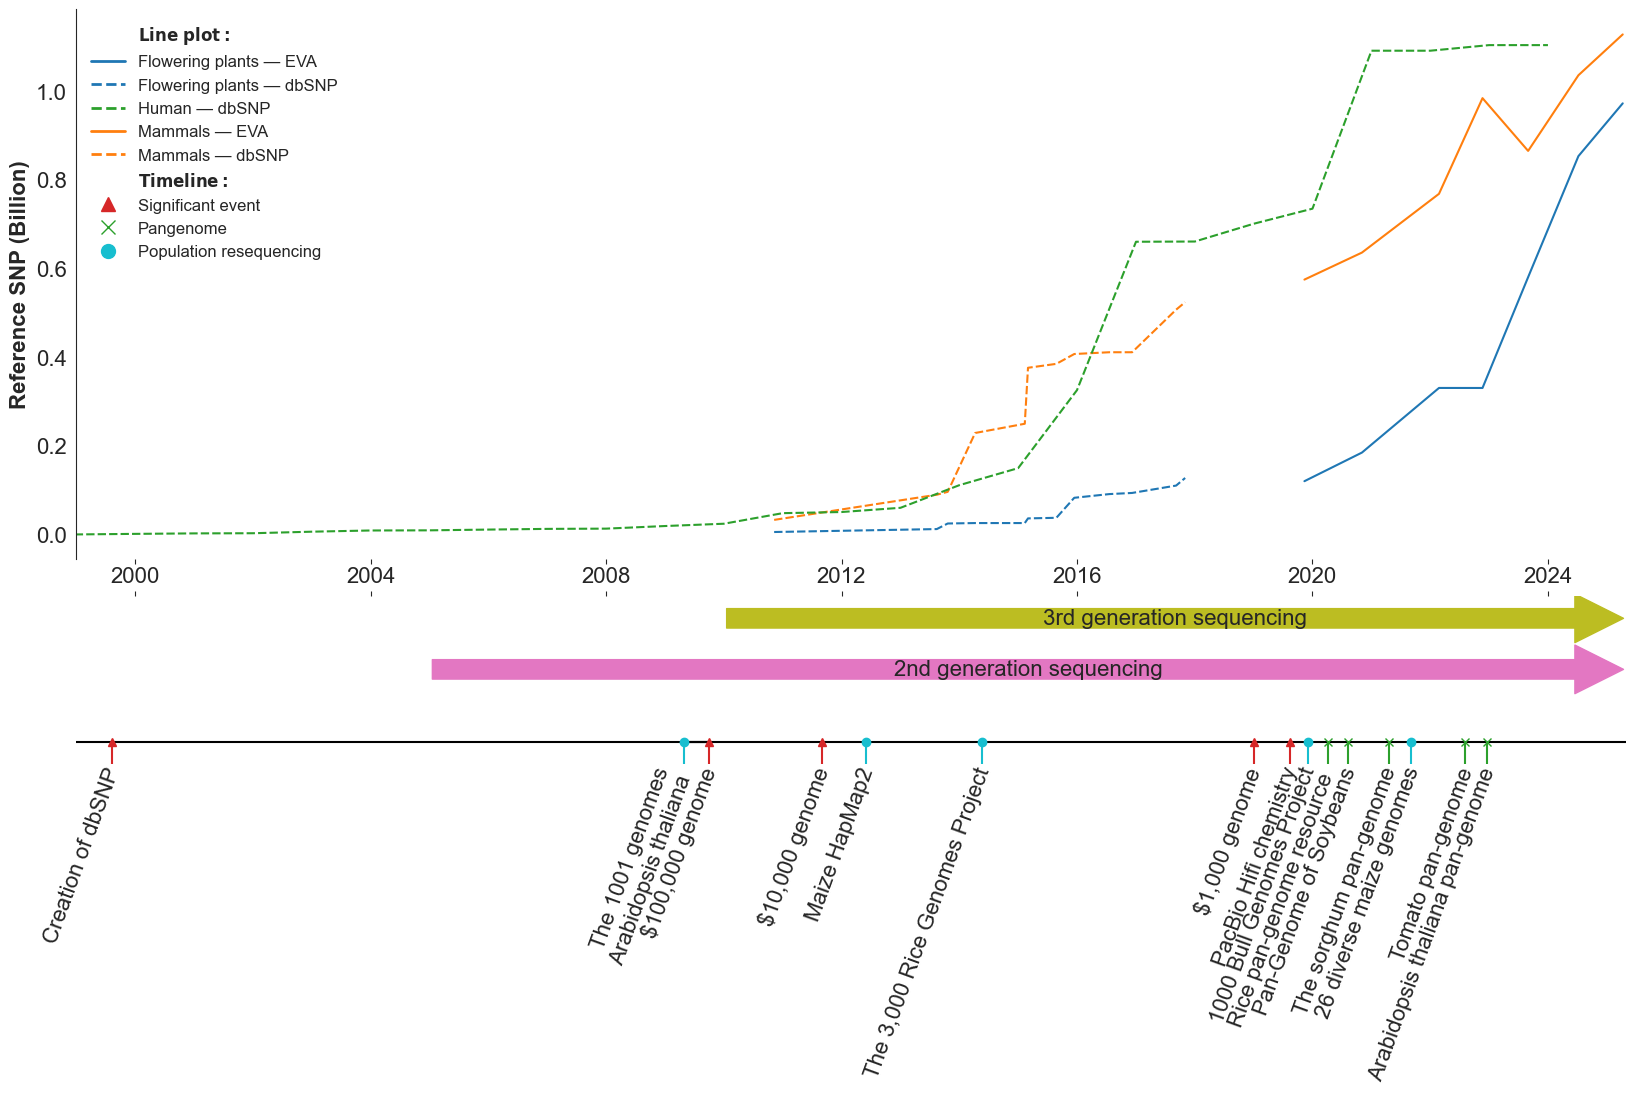

In [71]:

filtered_eva_metrics_per_class = eva_metrics_per_class.loc[eva_metrics_per_class['label'].isin(('Flowering plants', 'Mammals'))]
filtered_dbsnp_non_human_metrics = dbsnp_non_human_metrics.loc[dbsnp_non_human_metrics['label'].isin(('Flowering plants', 'Mammals'))]
combined_metrics = pd.concat([filtered_eva_metrics_per_class, dbsnp_human_metrics, filtered_dbsnp_non_human_metrics], axis='rows')
combined_metrics['Reference SNP (rs)'] = combined_metrics['Reference SNP (rs)'] / 1000000000
plot_agbiodata_fig(combined_metrics, events_dates_labels, range_dates_labels)

# Figure 1 including Flowering plants only


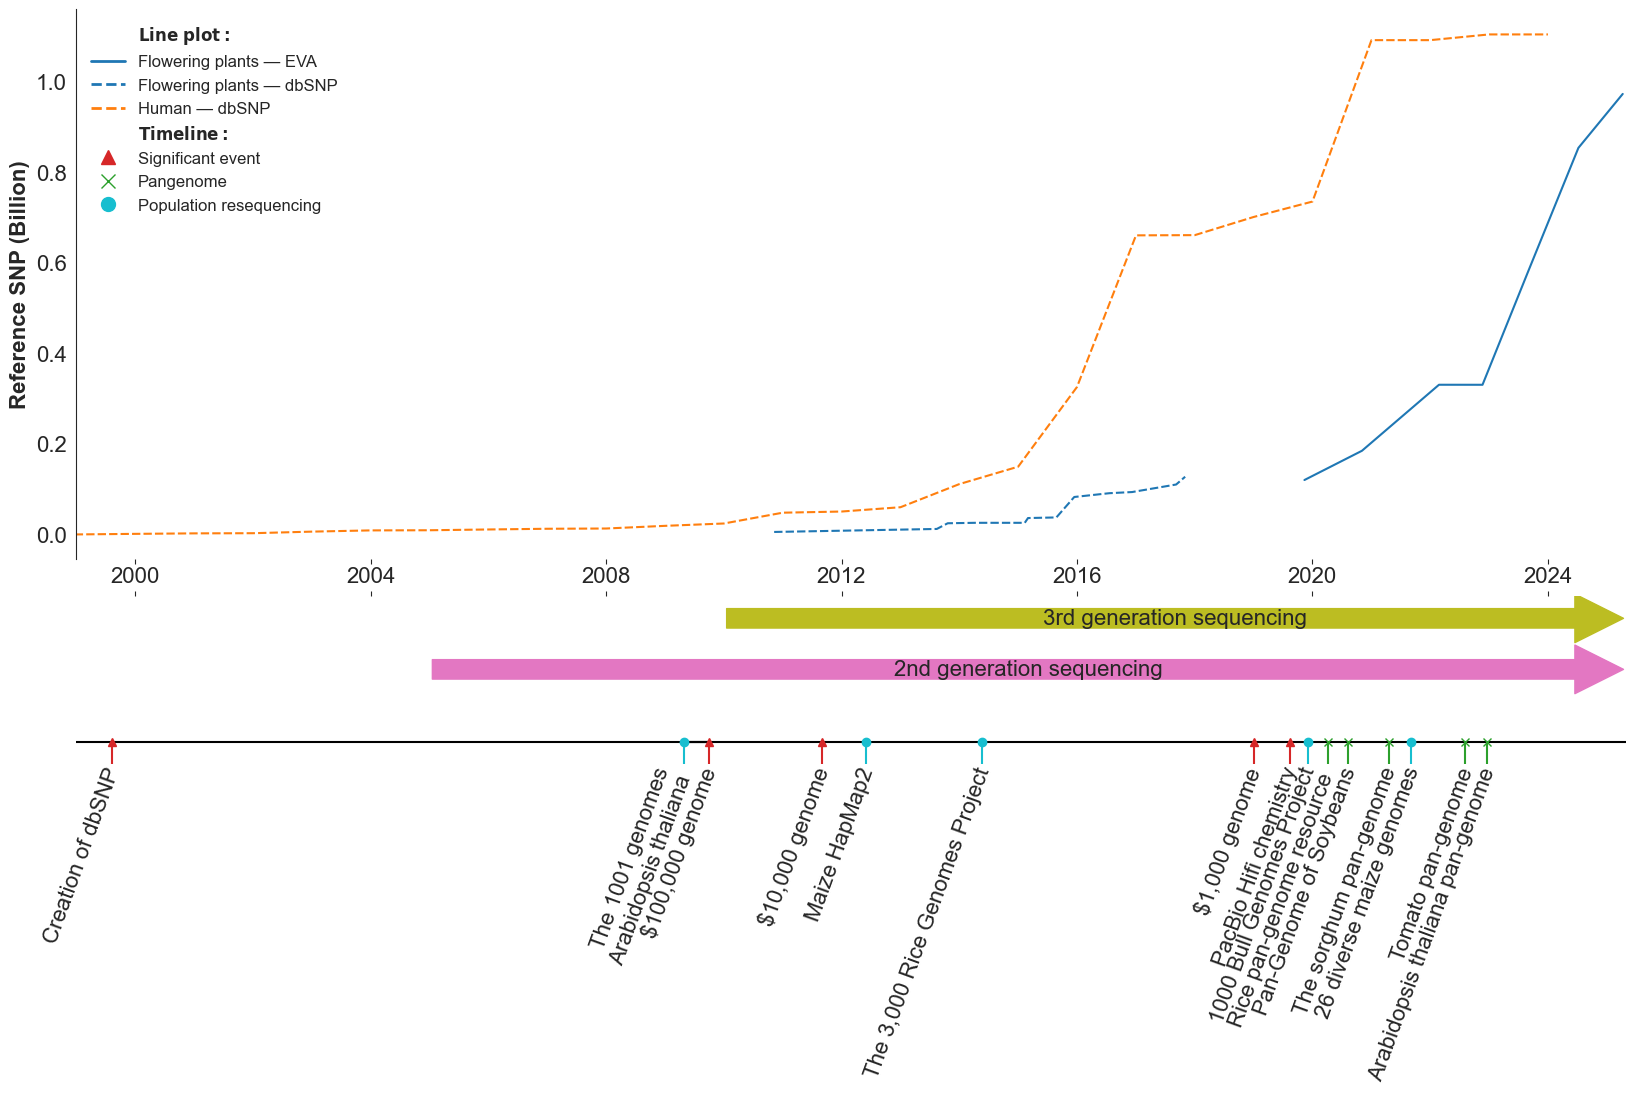

In [72]:
filtered_eva_metrics_per_class = eva_metrics_per_class.loc[eva_metrics_per_class['label'].isin(('Flowering plants',))]
filtered_dbsnp_non_human_metrics = dbsnp_non_human_metrics.loc[dbsnp_non_human_metrics['label'].isin(('Flowering plants',))]
combined_metrics = pd.concat([filtered_eva_metrics_per_class, dbsnp_human_metrics, filtered_dbsnp_non_human_metrics], axis='rows')
combined_metrics['Reference SNP (rs)'] = combined_metrics['Reference SNP (rs)'] / 1000000000
plot_agbiodata_fig(combined_metrics, events_dates_labels, range_dates_labels)

## Figure 1 including species of agricultural interests

/var/folders/y1/frdbbq352hz40j4scyzb_pjm0000gp/T/ipykernel_6893/3570575319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eva_metrics_per_agbio['label'] = 'Agricultural species'
/var/folders/y1/frdbbq352hz40j4scyzb_pjm0000gp/T/ipykernel_6893/3570575319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dbsnp_non_human_metrics_per_agbio['label'] = 'Agricultural species'


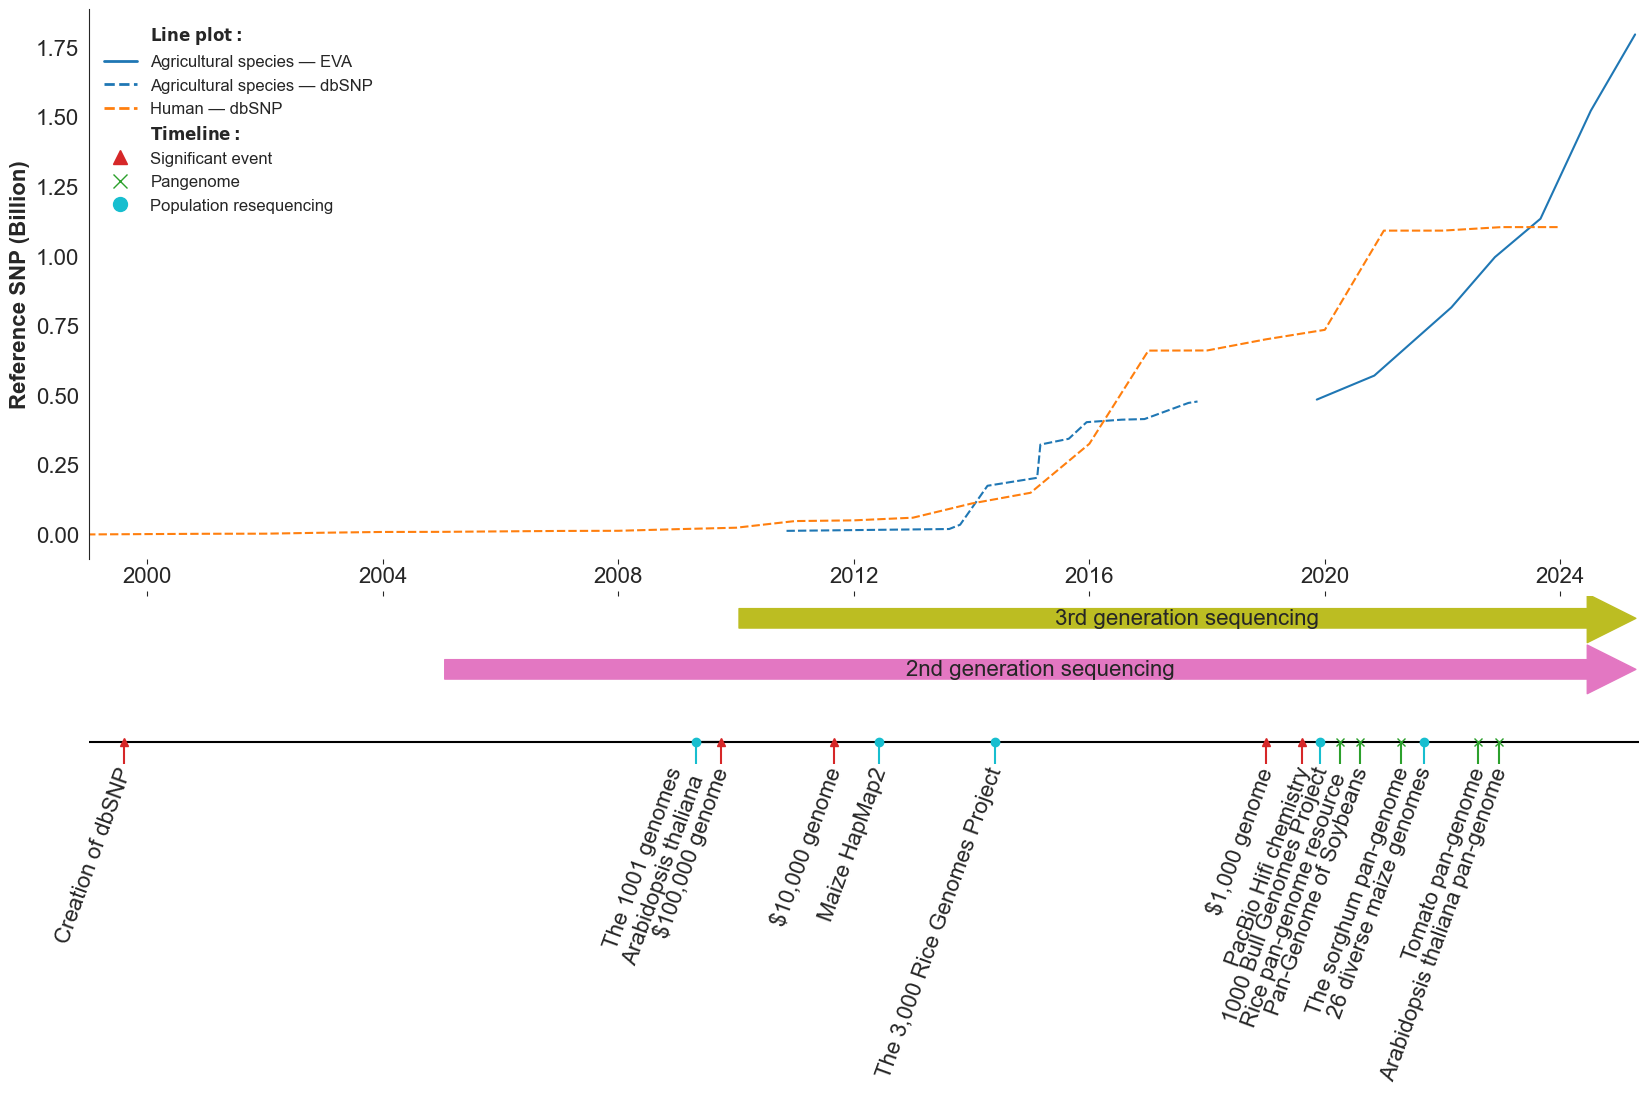

In [74]:
filtered_eva_metrics_per_agbio = eva_metrics_per_agbio.loc[eva_metrics_per_agbio['AgBio'].isin(('AgBio',))]
filtered_eva_metrics_per_agbio['label'] = 'Agricultural species'
filtered_dbsnp_non_human_metrics_per_agbio = dbsnp_metrics_per_agbio.loc[dbsnp_metrics_per_agbio['AgBio'].isin(('AgBio',))]
filtered_dbsnp_non_human_metrics_per_agbio['label'] = 'Agricultural species'
combined_metrics = pd.concat([filtered_eva_metrics_per_agbio, dbsnp_human_metrics, filtered_dbsnp_non_human_metrics_per_agbio], axis='rows')
combined_metrics['Reference SNP (rs)'] = combined_metrics['Reference SNP (rs)'] / 1000000000
plot_agbiodata_fig(combined_metrics, events_dates_labels, range_dates_labels)